In [16]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt

In [17]:
root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-75_date-20250708/behav/2025-07-08T14-07-51')

In [18]:
metadata_reader = utils.SessionData()
session_settings = utils.load_json(metadata_reader, root/"SessionSettings")
print(session_settings.iloc[0]['metadata'].sequences)

/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-75_date-20250708/behav/2025-07-08T14-07-51/SessionSettings/SessionSettings_*.jsonl
[[{'rewardConditions': [{'definition': [[{'command': 'OdorC', 'rewarded': False, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}], [{'command': 'OdorD', 'rewarded': False, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}], [{'command': 'OdorE', 'rewarded': False, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}], [{'command': 'OdorA', 'rewarded': True, 'minimumSamplingTime': 0.35, 'maximumSamplingTime': 1.0}]], 'position': 0}], 'interCommand': 'Purge', 'interCommandTime': 0.2, 'completionRequiresEngagement': True, 'skipSampling': False, 'enableTrialIndicator': True, 'enableRewardLocationIndicator': False, 'rewardAttempts': 0, 'responseTime': 99999.0, 'rewardAvailablePokeReset': False, 'interTrialInterval': 0.0, 'name': 'QuadrupleA_Stage1', 'defaultCommand': 'Default', 'maximumTime': 10.0, 'resetOnReward': True}, {'rewardCondition

In [19]:
# Load relevant data streams
behavior_reader = harp.create_reader('device_schemas/behavior.yml', epoch=harp.REFERENCE_EPOCH)
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)
video_reader = utils.Video()
video_data = utils.load_video(video_reader, root/"VideoData")

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# 'other' events
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior")
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior")

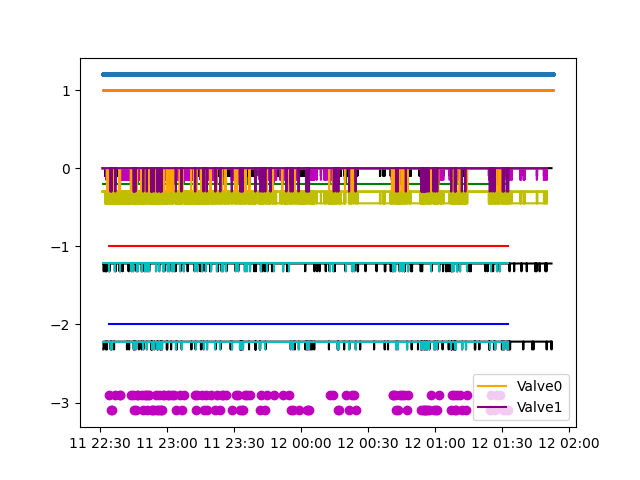

In [20]:
## Plot events of interest for debugging

# find initiation onsets, reward pokes
initiating_events = digital_input_data['DIPort0'][digital_input_data['DIPort0'] == True]
odour_led = utils.concat_digi_events(output_clear['DOPort0'], output_set['DOPort0'])
r1_led = utils.concat_digi_events(output_clear['DOPort1'], output_set['DOPort1'])
r2_led = utils.concat_digi_events(output_clear['DOPort2'], output_set['DOPort2'])

# Select Valve0 column from olfactometer_valves_0
valve0_data = olfactometer_valves_0['Valve0']
# Select Valve1 column from olfactometer_valves_0
valve1_data = olfactometer_valves_0['Valve1']

plt.figure()

# plot odour pokes events
plt.step(odour_led.index, odour_led * -0.2, where='post', c='g') # odour port LED
plt.step(digital_input_data.index, digital_input_data['DIPort0'] * -0.1, where='post', c='k') # odour port pokes

# plot odour valve events
plt.step(olfactometer_valves_0.index, olfactometer_valves_0 * -0.15, where='post', c='m') # olfactometer 1 valve events
plt.step(olfactometer_valves_1.index, olfactometer_valves_1 * -0.15 - 0.3, where='post', c='y') # olfactometer 2 valve events

# plot Valve0 specifically
plt.step(valve0_data.index, valve0_data * -0.3, where='post', c='orange', label='Valve0') # Valve0 events
# plot Valve1 specifically
plt.step(valve1_data.index, valve1_data * -0.3, where='post', c='purple', label='Valve1') # Valve1 events

# plot lick port A events
plt.step(r1_led.index, r1_led * 0.6 - 1, where='post', c='r') # lick port A LED
plt.step(digital_input_data.index, digital_input_data['DIPort1'] * -0.1 - 1.22, where='post', c='k') # lick port A pokes
plt.step(output_set.index, output_set["SupplyPort1"] * -0.1 - 1.22, where='post', c='c') # rewards for lick port A

# plot lick port B events
plt.step(r2_led.index, r2_led * 0.6 - 2, where='post', c='b') # lick port B LED
plt.step(digital_input_data.index, digital_input_data['DIPort2'] * -0.1 - 2.22, where='post', c='k') # lick port B pokes 
plt.step(output_set.index, output_set["SupplyPort2"] * -0.1 - 2.22, where='post', c='c') # rewards for lick port B

plt.scatter(video_data.index, np.ones((len(video_data.index), 1)) + 0.2, s=2.5)
plt.scatter(heartbeat.index, np.ones((len(heartbeat.index), 1)), s=0.1)
#plt.plot(analog_data.index, analog_data['AnalogInput0'] * 0.1)

# other events that may be useful to look at
plt.scatter(pulse_supply_1.index, np.ones((len(pulse_supply_1.index), 1)) - 3.9, c='m')
plt.scatter(pulse_supply_2.index, np.ones((len(pulse_supply_2.index), 1)) - 4.1, c='m')

plt.legend()  # Add legend to show the Valve0 label


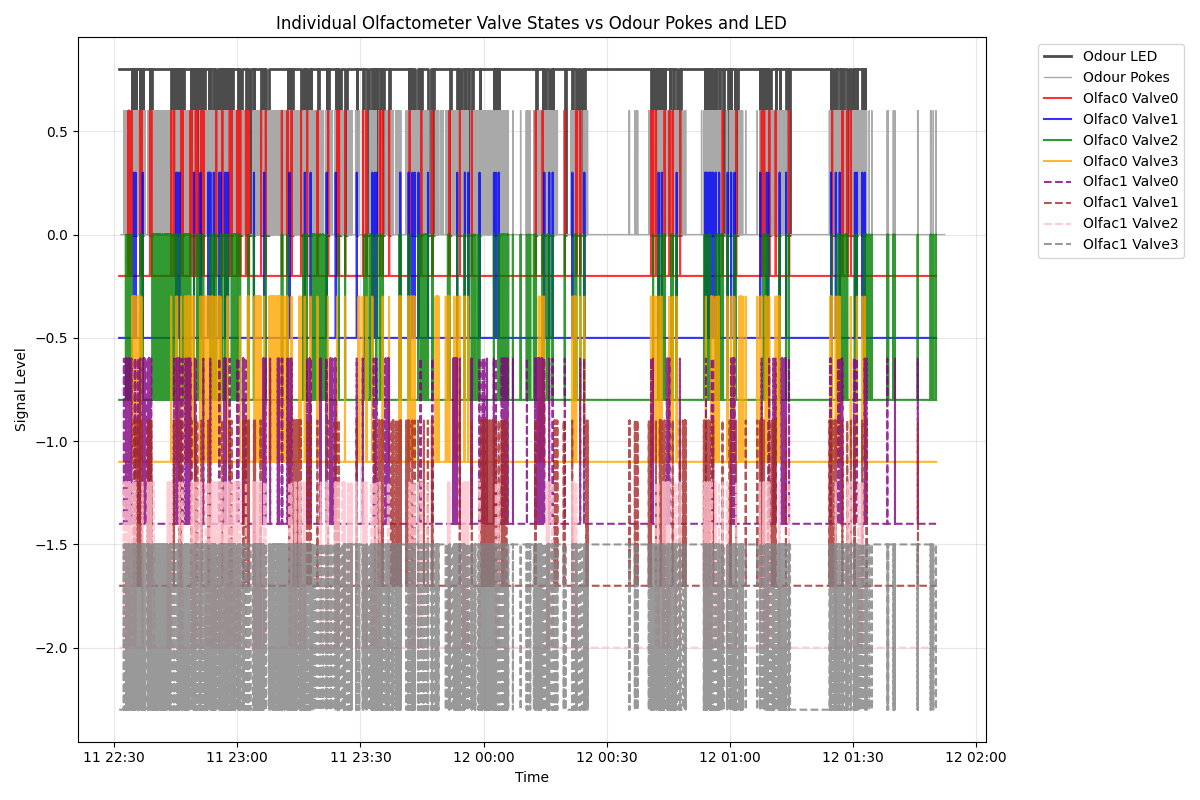

In [21]:
# Plot each individual olfactometer valve state with different colors against pokes
plt.figure(figsize=(12, 8))

# Define colors for different valves
valve_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Plot odour LED and pokes first
plt.step(odour_led.index, odour_led * 0.8, where='post', c='black', linewidth=2, label='Odour LED', alpha=0.7)
plt.step(digital_input_data.index, digital_input_data['DIPort0'] * 0.6, where='post', c='darkgray', linewidth=1, label='Odour Pokes')

# Plot individual valves from olfactometer 0
valve_offset = -0.2
for i, valve_col in enumerate(olfactometer_valves_0.columns):
    if valve_col in olfactometer_valves_0.columns:
        valve_data = olfactometer_valves_0[valve_col]
        color = valve_colors[i % len(valve_colors)]
        plt.step(valve_data.index, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'Olfac0 {valve_col}', alpha=0.8)
        valve_offset -= 0.3

# Plot individual valves from olfactometer 1
for i, valve_col in enumerate(olfactometer_valves_1.columns):
    if valve_col in olfactometer_valves_1.columns:
        valve_data = olfactometer_valves_1[valve_col]
        color = valve_colors[(i + len(olfactometer_valves_0.columns)) % len(valve_colors)]
        plt.step(valve_data.index, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'Olfac1 {valve_col}', alpha=0.8, linestyle='--')
        valve_offset -= 0.3

plt.xlabel('Time')
plt.ylabel('Signal Level')
plt.title('Individual Olfactometer Valve States vs Odour Pokes and LED')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()